In [1]:
from frechet_fda.data_generation_helpers import (
    gen_params_scenario_one,
    make_truncnorm_pdf,
)
from frechet_fda.distribution_tools import (
    get_optimal_range,
    make_distribution_objects,
    qdf_to_pdf,
    pdf_to_qdf,
    log_qd_transform,
    inverse_log_qd_transform,
    frechet_mean,
    quantile_distance,
    total_frechet_variance,
    k_frechet_variance
)
from frechet_fda.fda_funcs import (
    compute_centered_data,
    compute_cov_function,
    compute_fpc_scores,
    compute_principal_components,
    gen_qdtransformation_pcs,
    mode_of_variation,
    karhunen_loeve
)

In [2]:
# Set parameters
n = 200
grid_size = 10000
trunc = 3
mus, sigmas = gen_params_scenario_one(n)
# Sort sigmas, because when summing Distribution instances something goes wrong otherwise
sigmas.sort()

In [3]:
# Generate pdfs within truncation points
pdfs = make_truncnorm_pdf(-trunc, trunc, mus, sigmas, grid_size=grid_size)
# Make Distribution class objects
my_pdfs = make_distribution_objects(pdfs)
my_cdfs = [pdf.integrate() for pdf in my_pdfs]
my_qfs = [cdf.invert() for cdf in my_cdfs]
my_qdfs = [qf.differentiate() for qf in my_qfs]
# For numerical correction: shorten the range for smaller sigmas to get rid of
# numerical artifacts when computing integrals, derivatives and means later
new_ranges = get_optimal_range(my_pdfs)
# Generate pdfs again, this time within individual ranges
pdfs2 = [
    make_truncnorm_pdf(
        new_ranges[i][0], new_ranges[i][1], mus[i], sigmas[i], grid_size=grid_size,
    )[0]
    for i in range(n)
]

C:\Coding\thesis_frechet_fda\src\frechet_fda\data_generation_helpers.py:65: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 0.00045380448286858055
 In position: 199
 Performing normalization...
  warnings.warn(
C:\Coding\thesis_frechet_fda\src\frechet_fda\numerics_helpers.py:36: RuntimeWarning: divide by zero encountered in divide
  d_y[:-1] = np.diff(y_vals) / np.diff(d_x)
C:\Coding\thesis_frechet_fda\src\frechet_fda\data_generation_helpers.py:65: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.0512038445709138e-05
 In position: 0
 Performing normalization...
  warnings.warn(
C:\Coding\thesis_frechet_fda\src\frechet_fda\data_generation_helpers.py:65: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.1517970267549416e-05
 In position: 0
 Performing normalization...
  warnings.warn(
C:\Coding\thesis_frechet_fda\src\frec

In [4]:
# Generate all the distribution objects
new_pdfs = make_distribution_objects(pdfs2)
new_cdfs = [pdf.integrate() for pdf in new_pdfs]
new_qfs = [cdf.invert() for cdf in new_cdfs]
new_qdfs = [qf.differentiate() for qf in new_qfs]

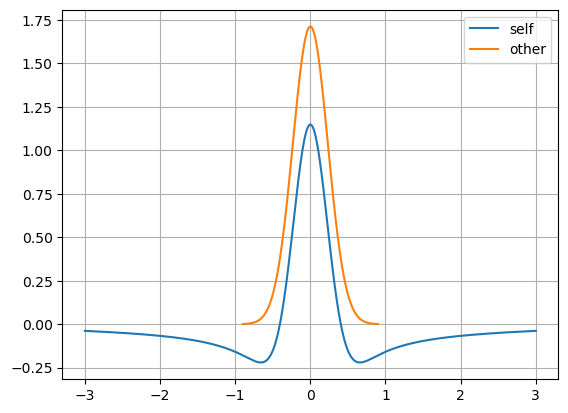

In [5]:
# Compute centered data, just to see whether it works
# One can clearly see how inappropriate it is to apply fda methods on densities
mean_pdf, centered_pdfs = compute_centered_data(new_pdfs)
centered_pdfs[sigmas.argmin()].compare(new_pdfs[sigmas.argmin()])

In [6]:
covariance_function = compute_cov_function(centered_pdfs)

In [7]:
eigenvalues, eigenfunctions = compute_principal_components(
    centered_pdfs[0].x, covariance_function,
)

## Transformation FPCA

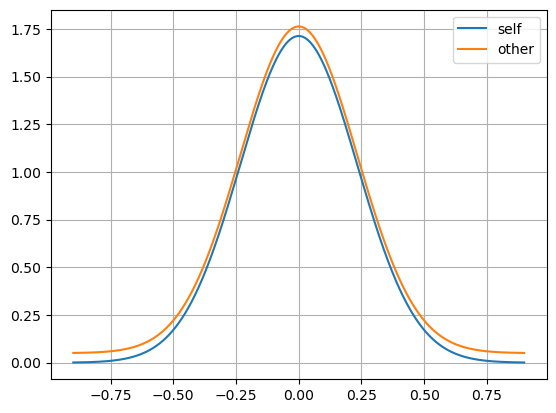

In [8]:
# Transform pdf sample, and test whether inverse works
log_qdfs = log_qd_transform(new_pdfs)
inverse_log_qdfs = inverse_log_qd_transform(log_qdfs)
inverse_log_qdfs[0].compare(new_pdfs[0] + 0.05)

In [9]:
# Compute FPCA objects
(
    mean_log_qdfs,
    eigenvalues_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
) = gen_qdtransformation_pcs(log_qdfs)

In [10]:
# Karhunen-Loève decomposition of transforms
truncated_representations_transforms = karhunen_loeve(
    mean_log_qdfs, eigenfunctions_log_qdfs, fpc_scores_log_qdfs, K=1
)

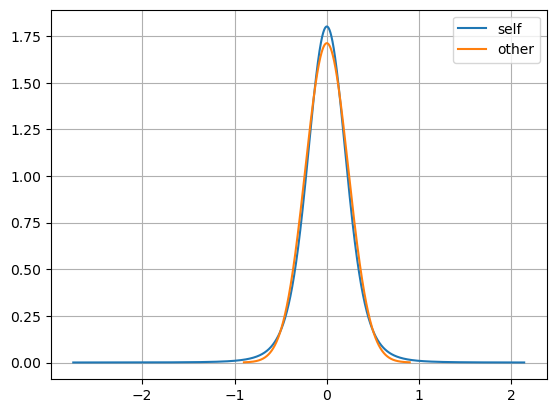

In [11]:
# Transform to density space
truncated_representations = inverse_log_qd_transform(truncated_representations_transforms)
truncated_representations[0].compare(new_pdfs[0])

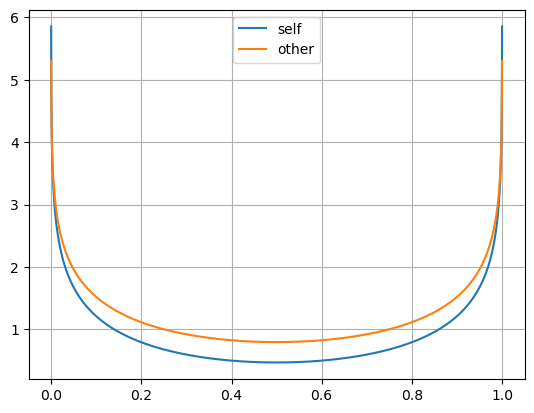

In [12]:
# Look at modes of variance of transformed functions
variation_modes_transforms = [
    mode_of_variation(
        mean_log_qdfs,
        eigval,
        eigfunc,
        alpha=5e-3
    )
    for eigval, eigfunc in zip(eigenvalues_log_qdfs, eigenfunctions_log_qdfs)
]
variation_modes_transforms[0].compare(variation_modes_transforms[1])

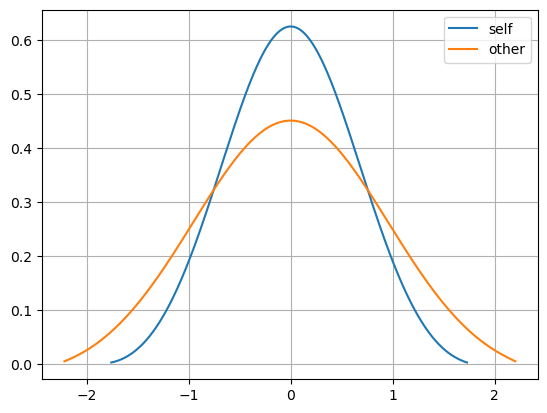

In [13]:
# Translate modes of variation to density space, compare first two modes
variation_modes = inverse_log_qd_transform(variation_modes_transforms)
variation_modes[0].compare(variation_modes[1])


In [14]:
# Compute Fréchet mean
f_mean = frechet_mean(new_pdfs)

In [16]:
total_var = total_frechet_variance(f_mean, new_pdfs)

In [17]:
var_explained = k_frechet_variance(total_var, new_pdfs, truncated_representations)
var_explained / total_var

0.9999216100029396

In [ ]:
quantile_distance(new_pdfs[3], frechet_mean)

0.6874892809884514